# Sections

[Data Loader](#Data-Loader)

[Loss functions](#Loss-functions)

[Network Architectures](#Network-Architectures)

[Generator and Discriminator test](#Generator-and-Discriminator-test)

[Training Helper Functions](#Training-Helper-Functions)

[Training GAN](#Training-GAN)

# TODO ITEMS

1. Put Tensorboard code in

DONE:

1. Normalize input to be in [0, 1], which Ledig's paper does and looks like GAN HW also put input into [-1, 1]
2. Normalize high res images to also be in [-1, 1], which is what Ledig's paper also does


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

################## LOGGING-BEGIN #########################
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
################## LOGGING-END ###########################

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


# Data Loader

In [15]:
tic = time()
count = 0
for x, y in loader_train:
    if np.isnan(x.numpy()).any():
        print("Found a Nan in x")
    if np.isnan(y.numpy()).any():
        print("Found a Nan in y")
    count += 1
    if count % 100 == 0:
        print(count)
toc = time()
print("Time taken: ", toc-tic)

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide


CREATED A NAN
high_min:  [[[-0.38889439]]

 [[-0.35545085]]]
high_max:  [[[-0.38889439]]

 [[ 1.46432562]]]
year index:  3
idx in year:  252
pr contain nans?  False
tas contains nans?  False
Found a Nan in y
100
200
300
400
500
600
700
800


Process Process-5:
  File "/home/shared/anaconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py", line 496, in __getitem__
    self.id.read(mspace, fspace, arr, mtype, dxpl=self._dxpl)
Process Process-8:
Process Process-7:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anacond

Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-f0be0f7339ae>", line 3, in <module>
    for x, y in loader_train:
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home

KeyboardInterrupt: 

In [10]:
nan

NameError: name 'nan' is not defined

In [3]:
for k in range(len(train_list)):

    file_name = 'sr_data/' + train_list[k]
    f = h5py.File(file_name, 'r')
    print("File: ", file_name)

#     print(list(f.keys()))

    for i in range(len(list(f.keys()))):
        print(list(f[list(f.keys())[i]].keys()), end="")
        if list(f[list(f.keys())[i]].keys()) != ['pr', 'tas']:
            print("Error in layer names")
    print()

#     for i in range(len(list(f.keys()))):
#         print(len(list(f[list(f.keys())[i]]['pr'])), ", ", end="")
#         if len(list(f[list(f.keys())[i]]['pr'])) != 365:
#             print("ERROR HERE!!!!!!!!!!!!!!!")

    print()
    for i in range(len(list(f.keys()))):
        if f[list(f.keys())[i]]['pr'][i].shape != (412, 424):
            print("ERROR IN SIZE OF IMAGE!!!!!")
#         print(f[list(f.keys())[0]]['pr'][0].shape)
    
    print()

In [13]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py# Adapt 

HEIGHT_INDEX = 200 # Row index at which the crop begins
WIDTH_INDEX = 200  # Column index at which the crop begins

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS_IN = 3
NUM_CHANNELS_OUT = 2

TRAIN_FILES = 10
VAL_FILES = 2
TEST_FILES = 0
YEARS_PER_FILE = 10
IMGS_PER_YEAR = 365

TRAIN_MODE = 0
VAL_MODE = 1
TEST_MODE = 2

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    elevation_file = 'dem.pkl'
    
    train_list = np.array([
        '1950s.hdf5',
        '1960s.hdf5',
        '1970s.hdf5',
        '1980s.hdf5',
        '1990s.hdf5',
        '2000s.hdf5',
        '2010s.hdf5',
        '2020s.hdf5',
        '2030s.hdf5',
        '2040s.hdf5'
    ])
    
    val_list = np.array([
        '2050s.hdf5',
        '2060s.hdf5'
    ])

    test_list = np.array([
        
    ])

    def __init__(self, root, train=True):
        
        self.root = os.path.expanduser(root)
        self.train = train  # training set or test set
        
        # load elevation data
        fo_in = open(os.path.join(self.root, self.elevation_file), 'rb')
        self.elevation = pickle.load(fo_in)
        fo_in.close()
        elev_mean = np.mean(self.elevation)
        elev_var = np.var(self.elevation)
        self.elevation = (self.elevation - elev_mean) / np.sqrt(elev_var)
        h,w = self.elevation.shape
        self.elevation = self.elevation.reshape((1,h,w))

    in_mean = np.array([1.9028055e-05, 284.676482])
    in_var = np.array([1.5503707e-09, 108.102618])
    out_mean = np.array([1.902273e-05, 284.676482])
    out_var = np.array([2.3926674e-09, 108.102618])
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (low_res, high_res)
        """
#         t1 = time()
        file_idx = index // (YEARS_PER_FILE * IMGS_PER_YEAR)
        img_in_file = index % (YEARS_PER_FILE * IMGS_PER_YEAR)
        year_idx = img_in_file // IMGS_PER_YEAR
        idx_in_year = img_in_file % IMGS_PER_YEAR
        
        f = None
        if self.train == TRAIN_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.train_list[file_idx]), 'r')
        elif self.train == VAL_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.val_list[file_idx]), 'r')
        elif self.train == TEST_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.test_list[file_idx]), 'r')
        
        yr = list(f.keys())[year_idx]
        pr =  f[yr]['pr'][idx_in_year]
        tas = f[yr]['tas'][idx_in_year]
        f.close()
        high_res = np.flip(np.concatenate((pr[np.newaxis,:,:], tas[np.newaxis,:,:])),axis=1)
        
        # Now crop the high_res as soon as we get it
        high_res = high_res[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # Also crop the elevation data to the same place
        elev_crop = self.elevation[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # get the input LR image from output HR image by blurring, cropping, then interpolating
        c,h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
        blurred = gaussian_filter(high_res, sigma = (0, 0.55, 0.55))
        half_res = blurred[:, ::2, ::2]
        # Code involved in interpolating the blurred image back up to high res resolution
        c,h2,w2 = half_res.shape
        x = np.arange(h2)
        y = np.arange(w2)
        xnew = np.arange(0, h2, h2/h1)
        ynew = np.arange(0, w2, w2/w1)
        low_res = np.zeros_like(high_res)
        for i in range(c):
            f = RectBivariateSpline(x, y, half_res[i, :, :])
            low_res[i, :, :] = f(xnew, ynew)
            
        # Normalize to mean 0, std 1 using precomputed statistics from the dataset
        low_res =  (low_res -  self.in_mean[:,np.newaxis,np.newaxis])  / np.sqrt(self.in_var[:,np.newaxis,np.newaxis])
        high_res = (high_res - self.out_mean[:,np.newaxis,np.newaxis]) / np.sqrt(self.out_var[:,np.newaxis,np.newaxis])
        
        # Add the elevation data to the input image
        low_res = np.concatenate((low_res, elev_crop))
        
        # Set the range of values of the training data from 0 to 1, and high res from -1 to 1, as they do in Ledig
        low_res -= np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_res /= np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        
        high_min = np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_max = np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_res = (high_res - high_min) / ((high_max - high_min) / 2) - 1
        if np.isnan(high_res).any():
            print("CREATED A NAN")
            print("high_min: ", high_min)
            print("high_max: ", high_max)
            print("year index: ", year_idx)
            print("idx in year: ", idx_in_year)
            print("pr contain nans? ", np.isnan(pr).any())
            print("tas contains nans? ", np.isnan(tas).any())
            
        
        # Gotta cast the lowres to float (from double) else it confuses the model, since model's standard
        # is to assume float
        low_res = torch.from_numpy(low_res).float() 
        high_res = torch.from_numpy(high_res).float()      
        
        #print(time()-t1)
        return low_res, high_res

    def __len__(self):
        if self.train:
            return len(self.train_in)
        else:
            return len(self.test_in)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [14]:
data_directory = '.'

##########################################################################################
#                                  BATCH_SIZE PARAMETER
BATCH_SIZE = 16
##########################################################################################


sr_train = SR_Dataset(data_directory, train=TRAIN_MODE)
loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)


sr_val = SR_Dataset(data_directory, train=VAL_MODE)
loader_val = DataLoader(sr_val, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(VAL_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)




# Old code

# sr_train = SR_Dataset(data_directory, train=True)
# loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE, 
#                           sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
#                          num_workers = 4)

# sr_val = SR_Dataset(data_directory, train=True) #, transform=transform, target_transform=transform)
# loader_val = DataLoader(sr_val, batch_size=BATCH_SIZE, 
#                        sampler=sampler.SubsetRandomSampler(range(VAL_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)))

#sr_test = SR_Dataset(data_directory, train=True, transform=transform)
#loader_test = DataLoader(sr_test, batch_size=batch_size)

In [6]:
# Check to make sure the range on the input and output images is correct, and they're the correct shape
testx, testy = sr_train.__getitem__(3)
print("x shape: ", testx.shape)
print("y shape: ", testy.shape)
print("x min: ", torch.min(testx))
print("x max: ", torch.max(testx))
print("y min: ", torch.min(testy))
print("y max: ",torch.max(testy))


x shape:  torch.Size([3, 64, 64])
y shape:  torch.Size([2, 64, 64])
x min:  tensor(0.)
x max:  tensor(1.)
y min:  tensor(-1.)
y max:  tensor(1.)


# Loss functions

In [7]:
def discriminator_loss(logits_real, logits_fake):
    """
    
    Taken from homework 3, GAN notebook
    
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data (real numbers). 
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data (real numbers).
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    # How often it mistakes real images for fake
    N = logits_real.shape[0]
    real_labels = torch.ones(N).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    try:
        L1 = BCE_Loss(logits_real, real_labels)
    except:
        print("GOT THE ERROR AGAIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("logits real shape: ", logits_real.shape)
        print("real labels shape: ", real_labels.shape)
        print("logits real: ", logits_real)
        print("real labels: ", real_labels)
        return
        
    
    # How often it gets fooled into thinking fake images are real
    fake_labels = torch.zeros(N).to(device=device, dtype=dtype)
    L2 = BCE_Loss(logits_fake, fake_labels)
    
#     print("L1 (how bad on real data): %f\t L2 (how bad on fake data): %f" % (L1, L2))
    
    loss = (L1 + L2)
    return loss, L1, L2

In [8]:
def generator_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Content loss - MSE loss for now. Ludig paper also suggests using
    # Euclidean distance between feature vector of true image and generated image, 
    # where we get the feature vector from a pretrained VGGnet. Probably wouldn't
    # work for us (at least pretrained) because climate data looks so different from normal pictures
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N).to(device=device, dtype=dtype)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    
    total_loss = content_loss + weight_param*adversarial_loss
#     print("Total loss: ", total_loss.cpu().detach().numpy())
#     print("content loss: ", content_loss.cpu().detach().numpy())
#     print("adversarial loss: ", adversarial_loss.cpu().detach().numpy())
    return total_loss, content_loss, adversarial_loss
    
    

In [9]:
def get_optimizer(model, lr=1e-3):
    """
    Copied from homework GAN notebook since I'll copy their training function too anyways
    
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, )
    return optimizer

# Network Architectures

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [11]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, H=IMG_HEIGHT, W=IMG_WIDTH):
        super().__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            Flatten(),
            nn.Linear(512*np.ceil(H/16)*np.ceil(W/16), 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.layers(x)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        return x + self.layers(x)

class UpscaleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 256, 3, stride=1, padding=0),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.layers(x)
        

#######################################################################################################
#   DO I NEED TO TURN BATCHNORM OFF AT TEST TIME TO COPY PAPER OR DOES PYTORCH DO THAT AUTOMATICALLY??
#######################################################################################################

class Generator(nn.Module):
    def __init__(self, num_channels, num_res_blocks=16, scale_factor=2):
#         upsample_block_num = int(math.log(scale_factor, 2))

        super().__init__()
        # Store the number of residual blocks, we need this number in the forward() function
        self.num_res_blocks = num_res_blocks
        
        self.initial_conv = nn.Sequential(
            nn.ReplicationPad2d(4),
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=0),
            nn.PReLU()
        )
        
        # List of residual blocks
        self.resBlocks = nn.ModuleList([ResidualBlock(64) for i in range(self.num_res_blocks)])

        self.post_resid_conv = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )
    
        # We chose to remove the pixelshuffle blocks and instead interpolate ahead of time
        # This allows us to leverage the fact that the elevation data is also high resolution
        # since if we used pixelshuffle, we would need to have the elevation data at lowres in input
#         self.num_upscale_blocks = scale_factor // 2
#         self.upscaleBlocks = nn.ModuleList([UpscaleBlock() for i in range(self.num_upscale_blocks)])
        
        # Instead, just do one conv-prelu block, without the pixelshuffle in between
        self.conv_prelu = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.PReLU()
        )
    
        self.final_conv = nn.Sequential(
            nn.ReplicationPad2d(4),
            nn.Conv2d(64, 2, 9, stride=1, padding=0)
        )


    def forward(self, x):
        initial_conv_out = self.initial_conv(x)
                
        res_block_out = self.resBlocks[0](initial_conv_out)
        for i in range(1, self.num_res_blocks):
            res_block_out = self.resBlocks[i](res_block_out)

        post_resid_conv_out = self.post_resid_conv(res_block_out) + initial_conv_out
        conv_prelu_out = self.conv_prelu(post_resid_conv_out)
        final_out = self.final_conv(conv_prelu_out)


        return F.tanh(final_out) 
#         return (F.tanh(block8) + 1) / 2  # From reference code, not sure why he does this to put it in [0 1]

# Generator and Discriminator test

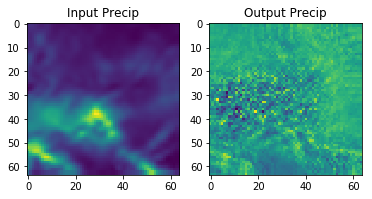

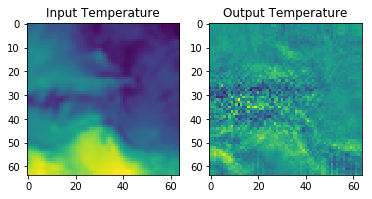

In [13]:
def test_Generator():
    h = 32
    w = h
#     x = torch.zeros((1, NUM_CHANNELS_IN, h, w), dtype=dtype) 
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    model = Generator(NUM_CHANNELS_IN, scale_factor=2)
    model = model.to(device=device)
    x = x.to(device=device, dtype=dtype)
    output = model(x)
#     print(np.amin(output[0,1,:,:].detach().numpy()))
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0, 0, :, :])
    plt.title("Input Precip")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0, 0, :, :])
    plt.title("Output Precip")
    plt.figure()
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0, 1, :, :])
    plt.title("Input Temperature")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0, 1, :, :])
    plt.title("Output Temperature")
    plt.show()
test_Generator()

In [14]:
def test_Discriminator():
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    print("x: ", x.shape)
    model = Discriminator(NUM_CHANNELS_IN)
    output = model(x)
    print(output.size())
    print(output)
test_Discriminator()

x:  torch.Size([1, 3, 64, 64])
torch.Size([1, 1])
tensor([[ 0.4980]])


# Training Helper Functions

In [15]:
def check_generator_accuracy(loader, model):
    model = model.to(device=device)
#     if loader.dataset.train == TRAIN_MODE:
#         print('Checking accuracy on train set')
#     elif loader.dataset.train == VAL_MODE:
#         print('Checking accuracy on validation set')
#     elif loader.dataset.train == TEST_MODE:
#         print('Checking accuracy on test set')
    model.eval() # set model to evaluation mode
    count, rmse_precip_ypred, rmse_precip_x, rmse_temp_ypred, rmse_temp_x = 0, 0, 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            rmse_precip_ypred += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_precip_x += torch.sqrt(torch.mean((x[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_temp_ypred += torch.sqrt(torch.mean((y_predicted[:,1,:,:]-y[:,1,:,:]).pow(2)))
            rmse_temp_x += torch.sqrt(torch.mean((x[:,1,:,:]-y[:,1,:,:]).pow(2)))
            count += 1
            
        rmse_precip_ypred /= count
        rmse_precip_x /= count
        rmse_temp_ypred /= count
        rmse_temp_x /= count
        print('RMSEs: \tInput precip: %.3f\n\tOutput precip: %.3f\n\tInput temp: %.3f\n\tOutput temp: %.3f\n\t' % 
              (rmse_precip_x, rmse_precip_ypred, rmse_temp_x, rmse_temp_ypred))
        
def check_discriminator_accuracy(loader, D, G):
    D = D.to(device=device)
    G = G.to(device=device)
#     if loader.dataset.train == TRAIN_MODE:
#         print('Checking accuracy on train set')
#     elif loader.dataset.train == VAL_MODE:
#         print('Checking accuracy on validation set')
#     elif loader.dataset.train == TEST_MODE:
#         print('Checking accuracy on test set')
    D.eval() # set model to evaluation mode
    G.eval()
    
    count, avg_true_pred, avg_fake_pred = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            true_pred = D(y)
            avg_true_pred += true_pred.sum()
            count += len(true_pred)
            
            fake_imgs = G(x)
            fake_pred = D(fake_imgs)
            avg_fake_pred += fake_pred.sum()
            
        avg_true_pred /= count
        avg_fake_pred /= count
        print("Average prediction score on real data: %f" % (avg_true_pred))
        print("Average prediction score on fake data: %f" % (avg_fake_pred))

In [16]:
# Helper functions for plotting
def plot_epoch(x, y_pred, y):
    figsize = (9,4)
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.title("Input Precip")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.title("Output Precip")
    plt.subplot(1,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.title("True Precip")
    
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,1,:,:].cpu().detach().numpy())
    plt.title("Input Temp")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,1,:,:].cpu().detach().numpy())
    plt.title("Output Temp")
    plt.subplot(1,3,3)
    plt.imshow(y[0,1,:,:].cpu().detach().numpy())
    plt.title("True Temp")
    plt.show()
    
def plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param):
    
    D_count = np.count_nonzero(D_real_L)
    G_count = np.count_nonzero(G_content)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(G_count), G_content[range(G_count)])
    plt.plot(range(G_count), G_advers[range(G_count)])
    plt.plot(range(G_count), G_content[range(G_count)] + weight_param*G_advers[range(G_count)])
    plt.legend(("Content", "Adversarial", "Total"))
    plt.title("Generator loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(D_count), D_real_L[range(D_count)])
    plt.plot(range(D_count), D_fake_L[range(D_count)])
    plt.plot(range(D_count), D_real_L[range(D_count)] + D_fake_L[range(D_count)])
    plt.legend(("Real Pic", "Fake Pic", "Total"))
    plt.title("Discriminator loss")
    plt.xlabel("Iteration")
    plt.show()

# Training GAN

In [17]:
################## LOGGING-BEGIN #########################
# how often to log images
save_img_every = 150
exp_name = 'experiments/all_data_1_lr_4-adversWP_1'
writer = SummaryWriter(exp_name)
################## LOGGING-END ###########################

In [18]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, G_iters=1, show_every=250, num_epochs=5):
    """
    FROM THE HOMEWORK
    
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    # Move the models to the correct device (GPU if GPU is available)
    D = D.to(device=device)
    G = G.to(device=device)
    
    # Put models in training mode
    D.train()
    G.train()
    
    print("Expected num iters: ", len(loader_train)*num_epochs)
    G_content = np.zeros(len(loader_train)*num_epochs*G_iters+1)
    G_advers = np.zeros(len(loader_train)*num_epochs*G_iters+1)
    D_real_L = np.zeros(len(loader_train)*num_epochs+1)
    D_fake_L = np.zeros(len(loader_train)*num_epochs+1)
    
    
    
    iter_count = 0
    G_iter_count = 0
    for epoch in range(num_epochs):
        for x,y in loader_train:
                
            high_res_imgs = y.to(device=device, dtype=dtype)
            logits_real = D(high_res_imgs)

            x.requires_grad_()
            low_res_imgs = x.to(device=device, dtype=dtype)
#             fake_images = G(low_res_imgs).detach()
            fake_images = G(low_res_imgs)
            logits_fake = D(fake_images)
    
            # Update for the discriminator
            try:
                d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)
            except:
                print("GOT THE ERROR!")
                print("x shape: ", x.shape)
                print("y shape: ", y.shape)
                print("x min: ", torch.min(x))
                print("x max: ", torch.max(x))
                print("y min: ", torch.min(y))
                print("y max: ", torch.max(y))
                print("fake images min: ", torch.min(fake_images))
                print("fake images max: ", torch.max(fake_images))
                print("logits_fake min: ", torch.min(logits_fake))
                print("logits_fake max: ", torch.max(logits_fake))
                print("logits_real min: ", torch.min(logits_real))
                print("logits_real max: ", torch.max(logits_real))
                break
            D_solver.zero_grad()
            d_total_error.backward()
            D_solver.step()

            
            for i in range(G_iters):
                # Update for the generator
                fake_images = G(low_res_imgs)
                logits_fake = D(fake_images)
                gen_logits_fake = D(fake_images)
                weight_param = 1 # Weighting put on adversarial loss
                g_error, G_content[G_iter_count], G_advers[G_iter_count] = generator_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=weight_param)
                G_solver.zero_grad()
                g_error.backward()
                G_solver.step()
                G_iter_count += 1
                
                # Experimenting
#                 g_error, g_content, g_advers = generator_loss(fake_images, high_res_imgs, gen_logits_fake, weight_param=1e3)
#                 G_content[G_iter_count] = g_content
#                 G_advers[G_iter_count] = g_advers
#                 G_solver.zero_grad()
#                 g_advers.backward()
#                 G_solver.step()

            ################## LOGGING-BEGIN #########################
            writer.add_scalar('D Loss (Real)', D_real_L[iter_count], iter_count)
            writer.add_scalar('D Loss (Fake)', D_fake_L[iter_count], iter_count)
            writer.add_scalar('D Loss (Total)', d_total_error, iter_count)
            writer.add_scalar('G Loss (Content)', G_content[iter_count], iter_count)
            writer.add_scalar('G Loss (Adv)', G_advers[iter_count], iter_count)
            writer.add_scalar('G Loss (Total)', g_error, iter_count)
            if iter_count % save_img_every == 0:
                # precip
                input_precip_grid = vutils.make_grid(x[0, 0, :, :])
                writer.add_image('Input precipitation', input_precip_grid, iter_count)
                output_precip_grid = vutils.make_grid(fake_images[0, 0, :, :])
                writer.add_image('Output precipitation', output_precip_grid, iter_count)
                true_precip_grid = vutils.make_grid(y[0, 0, :, :])
                writer.add_image('True precipitation', true_precip_grid, iter_count)
                # temp
                input_temp_grid = vutils.make_grid(x[0, 1, :, :])
                writer.add_image('Input temperature', input_temp_grid, iter_count)
                output_temp_grid = vutils.make_grid(fake_images[0, 1, :, :])
                writer.add_image('Output temperature', output_temp_grid, iter_count)
                true_temp_grid = vutils.make_grid(y[0, 1, :, :])
                writer.add_image('True temperature', true_temp_grid, iter_count)
            ################## LOGGING-END ###########################

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count,d_total_error.item(),g_error.item()))
                plot_epoch(x, fake_images, y)
                plot_loss(G_content, G_advers, D_real_L, D_fake_L, weight_param)
                print()
            iter_count += 1
    print("FINAL ITER COUNT: ", iter_count)

Expected num iters:  2282


/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0, Iter: 0, D: 0.764, G:6.015


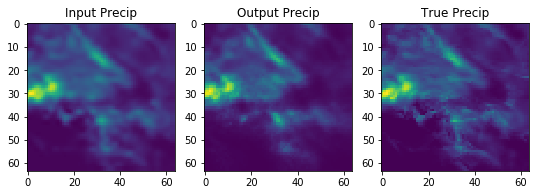

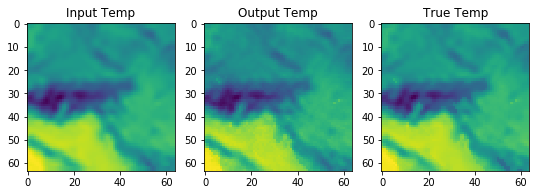

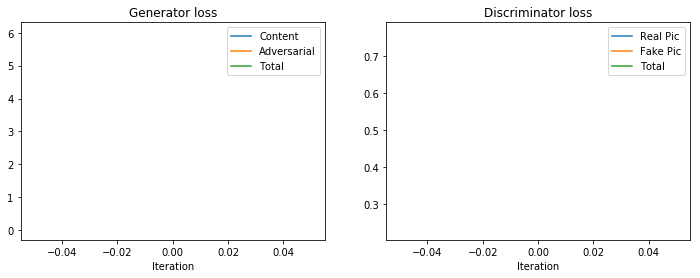


Epoch: 0, Iter: 150, D: 0.815, G:2.976


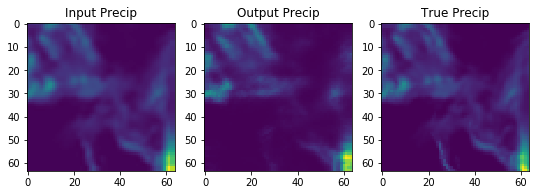

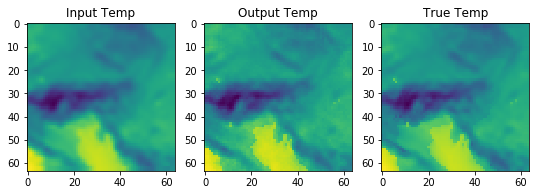

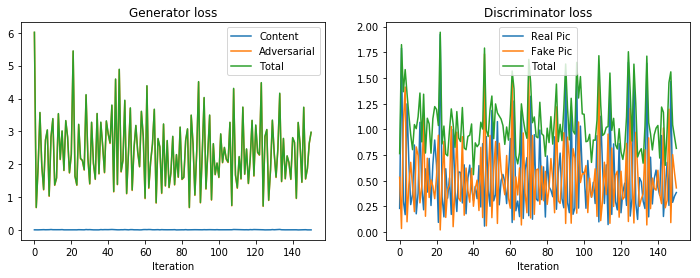

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide


GOT THE ERROR AGAIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
logits real shape:  torch.Size([16, 1])
real labels shape:  torch.Size([16])
logits real:  GOT THE ERROR!
x shape:  torch.Size([16, 3, 64, 64])
y shape:  torch.Size([16, 2, 64, 64])
x min:  tensor(0.)
x max:  tensor(1.)
y min:  tensor(nan.)
y max:  tensor(nan.)


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generated/../THCReduceAll.cuh:339

In [19]:


D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

# Initialize the Generator to the checkpoint created when training it alone
# G.load_state_dict(torch.load('training_Generator_checkpoint.pt'))

# Load the states from training on just one decade of data
G.load_state_dict(torch.load('GAN_Generator_checkpoint_1.pt'))
D.load_state_dict(torch.load('GAN_Discriminator_checkpoint_1.pt'))


D_solver = get_optimizer(D, lr=1e-4)
G_solver = get_optimizer(G, lr=1e-4)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, G_iters=1, show_every=150, num_epochs=1)

In [47]:
check_generator_accuracy(loader_val, G)

RMSEs: 	Input precip: 0.988
	Output precip: 0.193
	Input temp: 0.440
	Output temp: 0.098
	


In [62]:
check_discriminator_accuracy(loader_val, D, G)

True count:  3650
Fake count:  3650
Average prediction score on real data: 0.663451
Average prediction score on fake data: 0.322170


In [20]:
torch.save(D.cpu().state_dict(), 'GAN_Discriminator_checkpoint_2_middle.pt')
torch.save(G.cpu().state_dict(), 'GAN_Generator_checkpoint_2_middle.pt')

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generic/THCTensorCopy.c:70

Expected num iters:  11410


/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter: 0, D: 0.6316, G:4.885


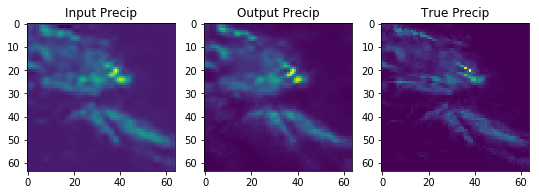

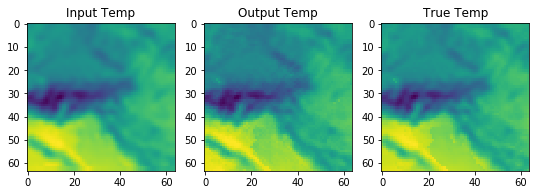

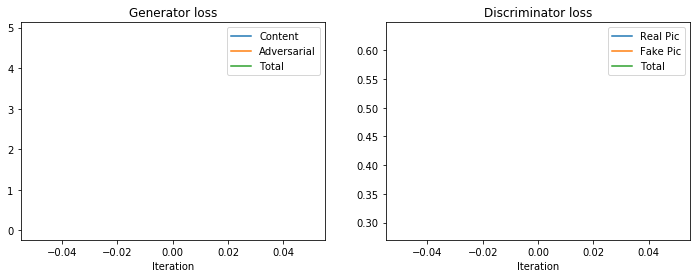


Iter: 150, D: 0.8578, G:2.6


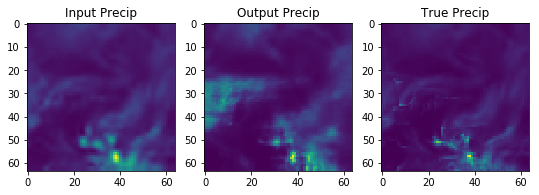

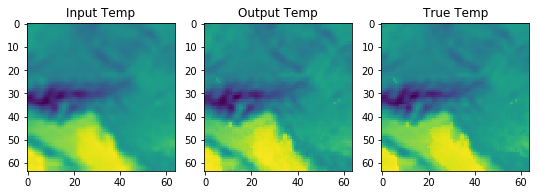

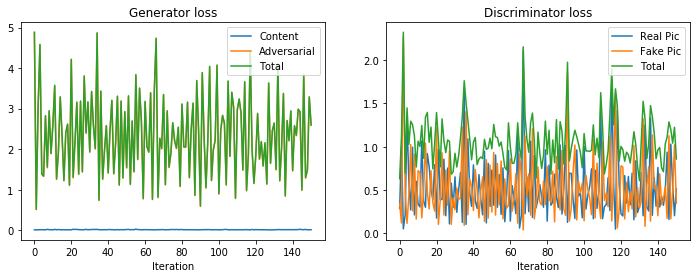


Iter: 300, D: 0.6643, G:3.892


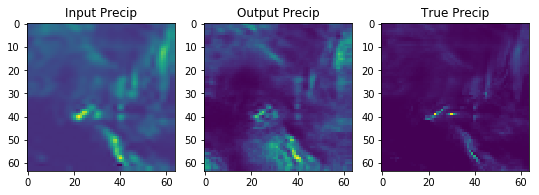

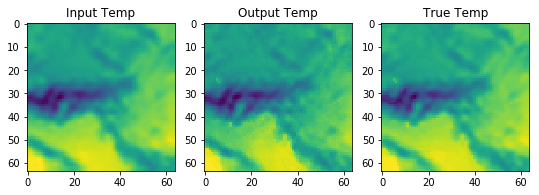

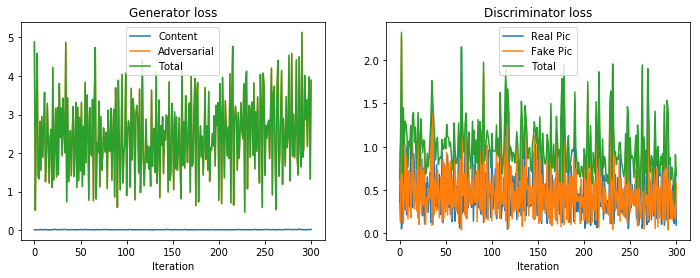


Iter: 450, D: 1.192, G:6.064


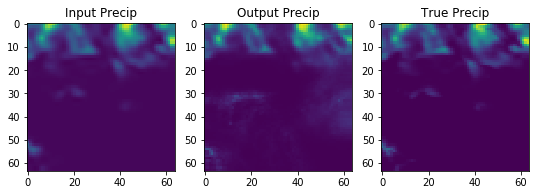

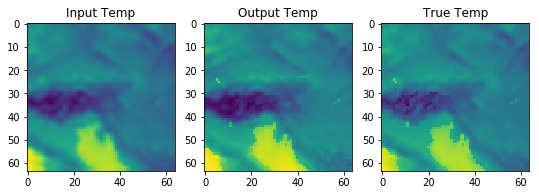

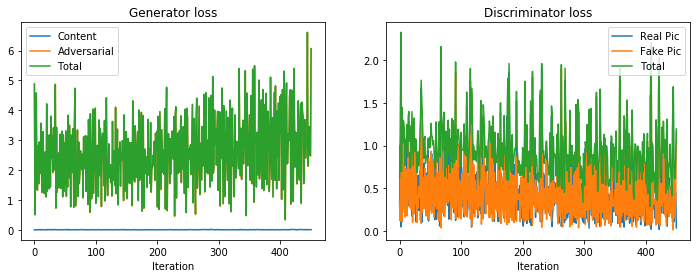


Iter: 600, D: 0.8483, G:2.583


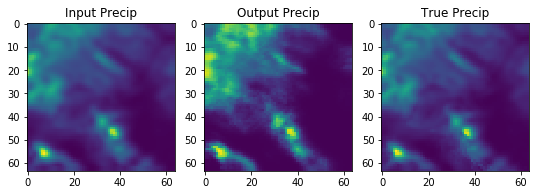

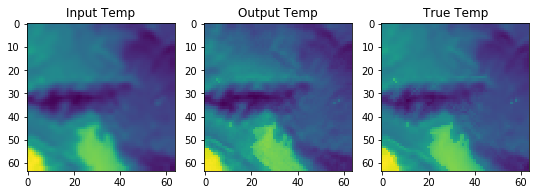

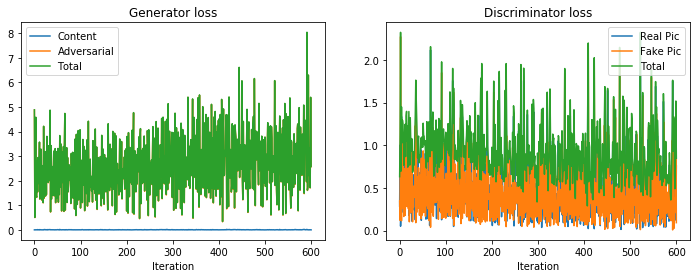


Iter: 750, D: 0.5508, G:3.677


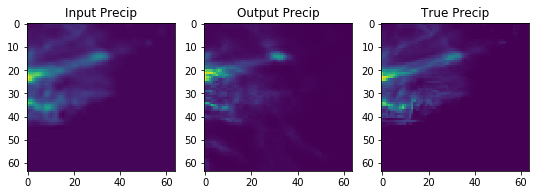

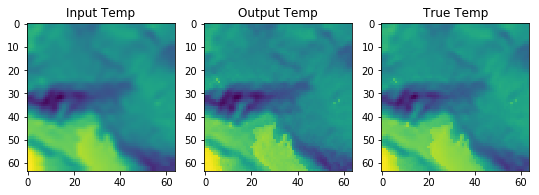

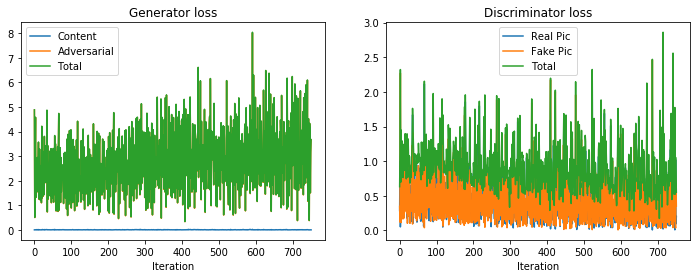


Iter: 900, D: 0.6907, G:3.723


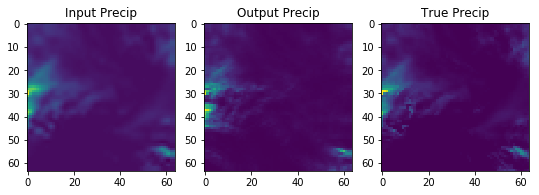

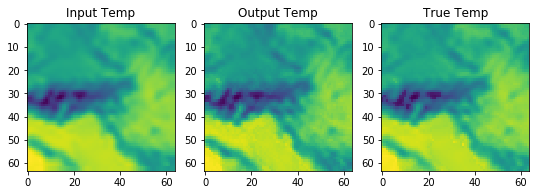

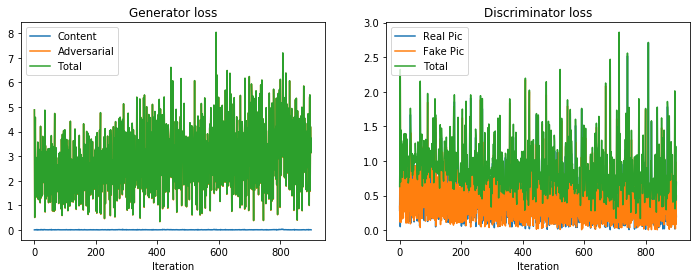


Iter: 1050, D: 0.5785, G:2.588


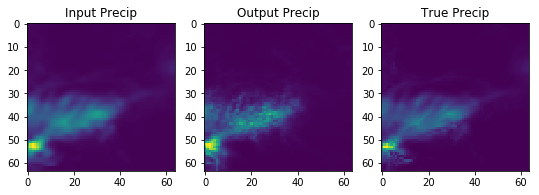

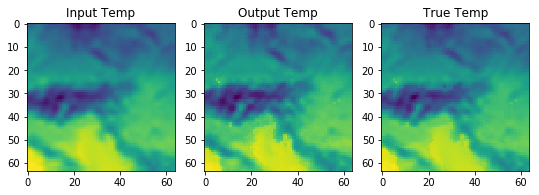

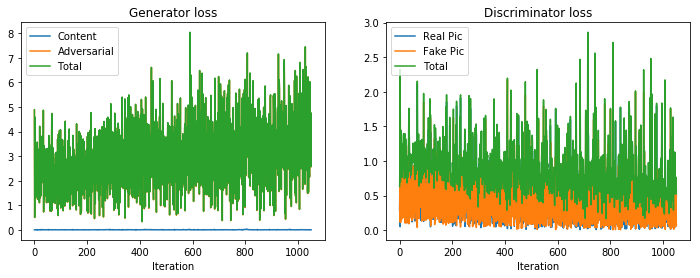


Iter: 1200, D: 0.6362, G:6.135


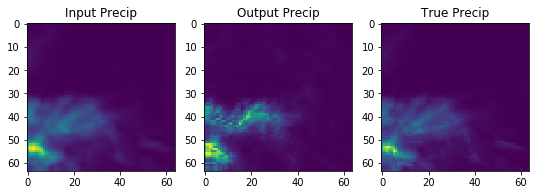

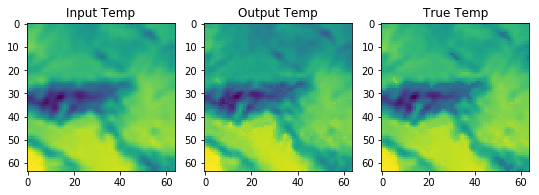

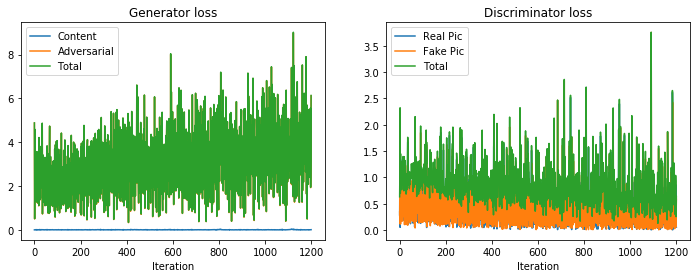


Iter: 1350, D: 0.5655, G:4.471


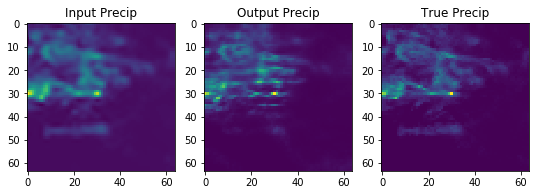

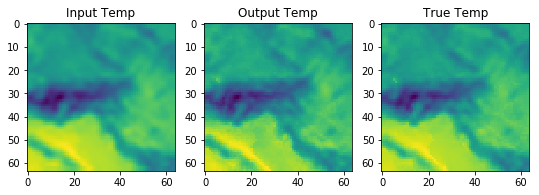

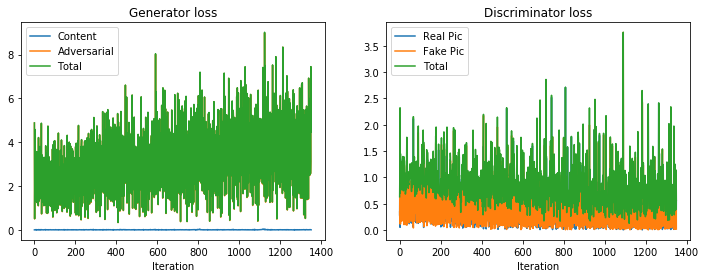

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide


RuntimeError: reduce failed to synchronize: device-side assert triggered

In [18]:
# SAVING FOR POSTERITY OF WHAT THE ERROR WAS

D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

# Initialize the Generator to the checkpoint created when training it alone
# G.load_state_dict(torch.load('training_Generator_checkpoint.pt'))

# Load the states from training on just one decade of data
G.load_state_dict(torch.load('GAN_Generator_checkpoint_1.pt'))
D.load_state_dict(torch.load('GAN_Discriminator_checkpoint_1.pt'))


D_solver = get_optimizer(D, lr=1e-4)
G_solver = get_optimizer(G, lr=1e-4)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, G_iters=1, show_every=150, num_epochs=5)

In [22]:
# Function to just train generator first, since it doesn't seem to do well in the GAN setup 
# when it starts from a random initialization
def train_generator(optimizer, model, print_every=10, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][0].cpu().detach().numpy())
                plt.title("Input Precip")
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][0].cpu().detach().numpy())
                plt.title("Output Precip")
                plt.subplot(1,3,3)
                plt.imshow(y[0][0].cpu().detach().numpy())
                plt.title("True Precip")
                plt.show()
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][1].cpu().detach().numpy())
                plt.title("Input Temp")
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][1].cpu().detach().numpy())
                plt.title("Output Temp")
                plt.subplot(1,3,3)
                plt.imshow(y[0][1].cpu().detach().numpy())
                plt.title("True Temp")
                plt.show()
                
                #check_accuracy(loader_val, model)
                
            del x, y, loss
            
    # At the end of training, save the model's state
    torch.save(model.cpu().state_dict(), 'training_Generator_checkpoint.pt')

Iteration 0, loss = 0.4791


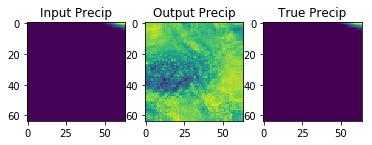

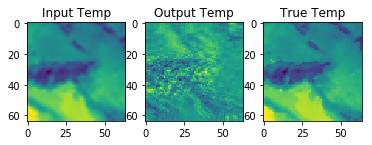

Iteration 10, loss = 0.0237


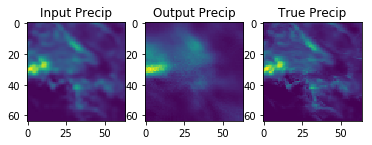

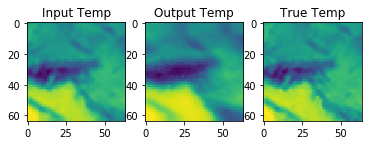

Iteration 20, loss = 0.0149


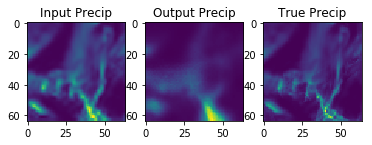

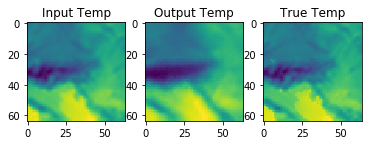

Iteration 30, loss = 0.0127


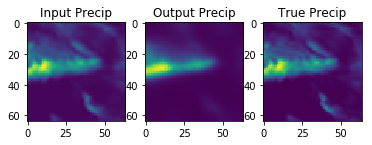

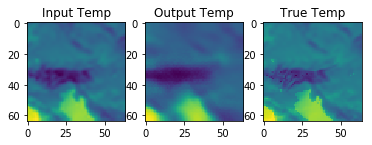

Iteration 40, loss = 0.0104


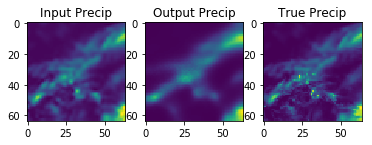

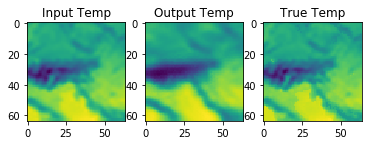

Iteration 50, loss = 0.0103


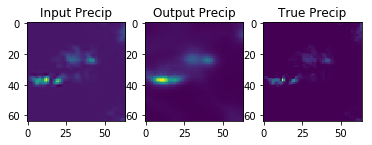

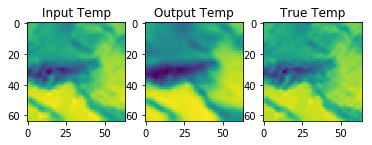

Iteration 60, loss = 0.0091


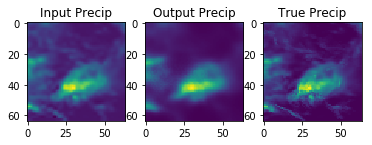

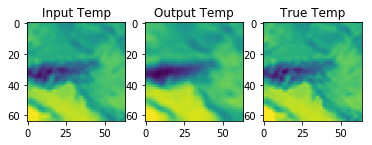

Iteration 70, loss = 0.0083


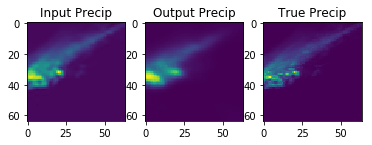

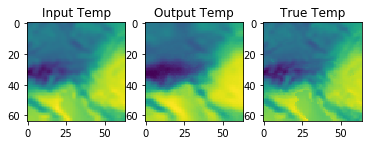

In [24]:
learning_rate = 1e-4

model = Generator(3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_generator(optimizer, model, epochs=1)

In [40]:
torch.save(model.cpu().state_dict(), 'training_Generator_checkpoint.pt')

Expected num iters:  18320


/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter: 0, D: 1.398, G:0.0995


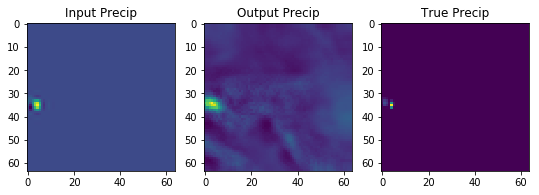

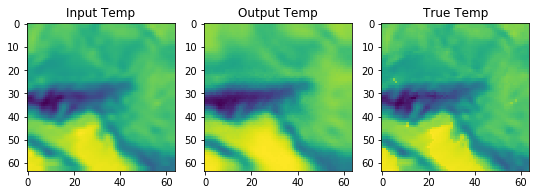

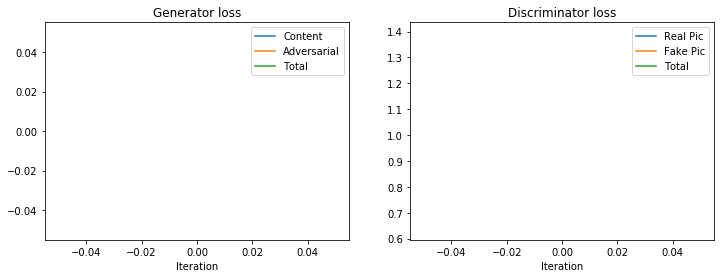


Iter: 20, D: 2.109, G:0.09929


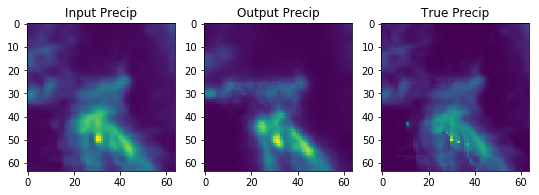

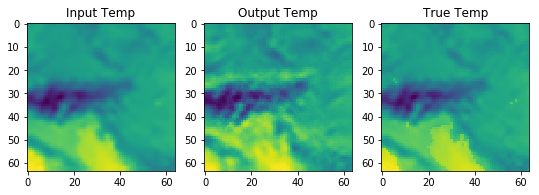

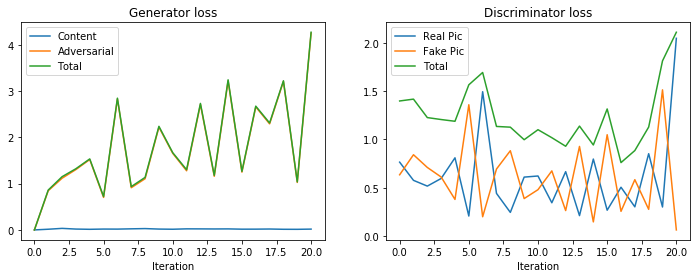


Iter: 40, D: 0.6875, G:0.175


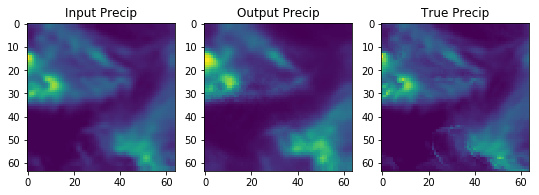

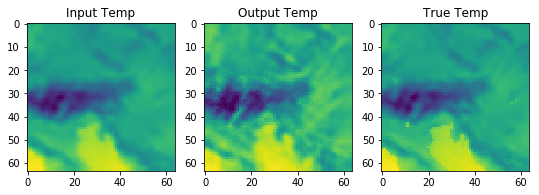

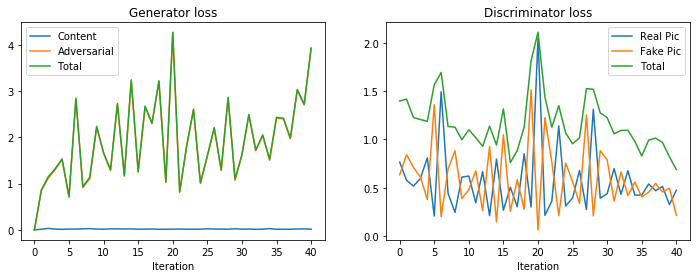


Iter: 60, D: 1.427, G:0.2411


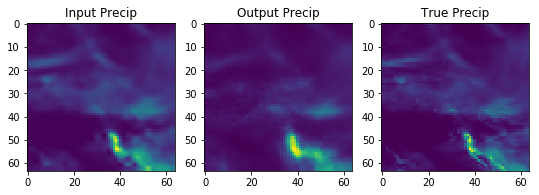

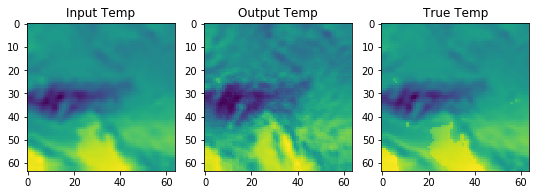

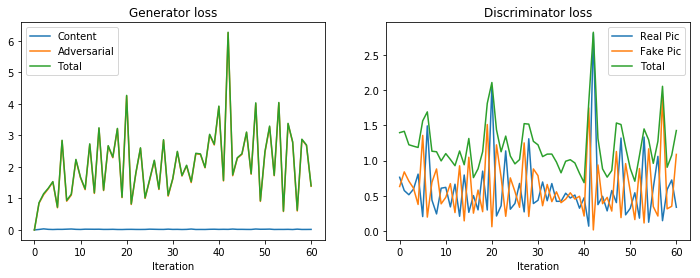


Iter: 80, D: 1.57, G:0.4265


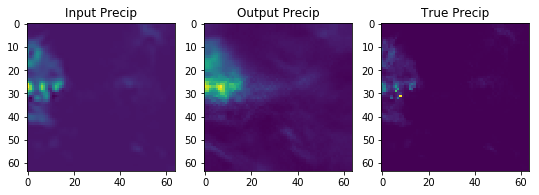

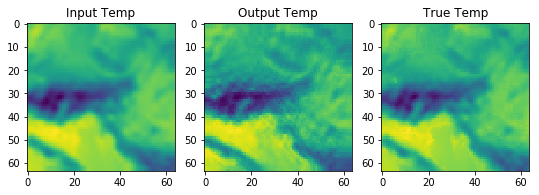

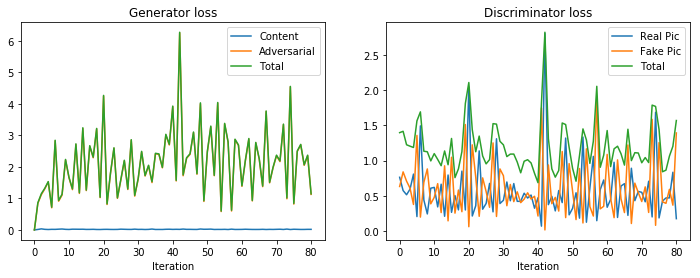


Iter: 100, D: 1.966, G:0.0768


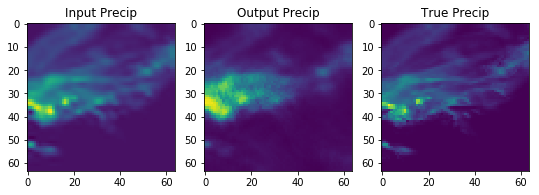

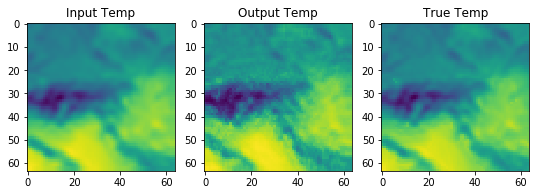

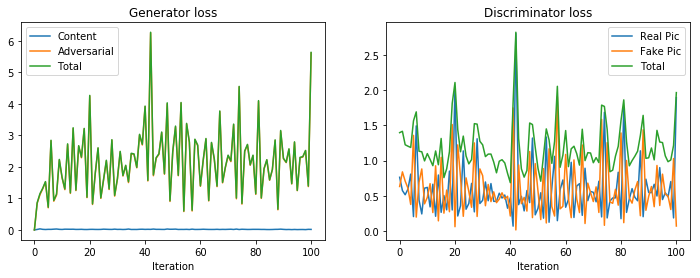

Process Process-12:
Process Process-11:
Process Process-9:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
  File "/home/shared/anaconda3/l

KeyboardInterrupt: 

In [21]:
D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

# Initialize the Generator to the checkpoint created when training it alone
G.load_state_dict(torch.load('training_Generator_checkpoint.pt'))

D_solver = get_optimizer(D, lr=1e-4)
G_solver = get_optimizer(G, lr=1e-4)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, G_iters=1, show_every=20)